<a href="https://colab.research.google.com/github/aapo-kossi/christmas_tree_spectrogram/blob/master/megalovania_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Define the animation speed of the spectrogram and the source files for the sound and led coordinates in GIFT format

In [1]:
fps = 60.0

In [2]:
src = 'https://archive.org/download/TobyFoxMegalovania/Toby%20Fox%20-%20Megalovania.mp3'

In [3]:
led_src = "https://www.dropbox.com/s/lmccfutftplhh3b/coords_2021.csv?dl=1"

Dependencies

In [4]:
!pip install pydub
import pydub
import requests
import scipy
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import colorsys
import pandas as pd
import time

Upload files to session

In [5]:
doc = requests.get(src)
with open('song.mp3','wb') as f:
  f.write(doc.content)

In [6]:
led_doc = requests.get(led_src)
with open('coords.csv','wb') as f:
  f.write(led_doc.content)

Generate two spectrograms, one for the higher frequency range and one for the lower frequencies (bass) that trades temporal resolution for frequency resolution

In [7]:
pydub.AudioSegment.from_mp3("song.mp3").export("song.wav", format="wav")

<_io.BufferedRandom name='song.wav'>

In [8]:
sample_rate, samples = wavfile.read('song.wav')
samples = (samples[:,0]+samples[:,1]) / 2
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, scaling='spectrum',window=scipy.signal.windows.tukey(16384 // 2, alpha=1.0), noverlap=16000//2)

In [9]:
low_frequencies, low_times, low_spectrogram = signal.spectrogram(samples, sample_rate, scaling='spectrum',window=scipy.signal.windows.tukey(16384*4, alpha=1.0), noverlap=8000*7)

In [10]:
low_cutoff, boundary, high_cutoff = (80,250,5000)

Visualize the spectrograms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


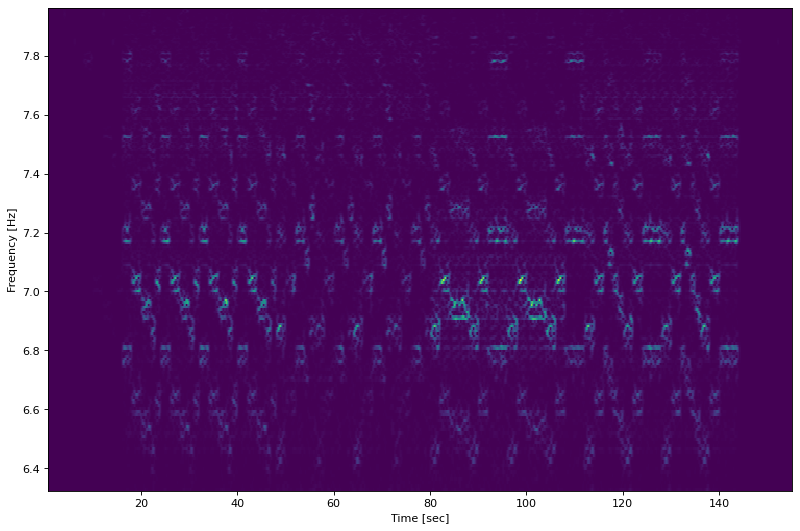

In [11]:
plt.figure(figsize=(12, 8), dpi=80)
low_freqs = np.where((low_frequencies >= low_cutoff) & (low_frequencies <= boundary))[0]
low_compat_freqs = np.expand_dims(low_frequencies, 1)
sqrt_spec = np.clip(low_spectrogram * np.log(low_compat_freqs), 0.0, (low_spectrogram*np.log(low_compat_freqs)).max())
plt.pcolormesh(low_times, np.log2(low_frequencies[low_freqs]), sqrt_spec[low_freqs,:])
# plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


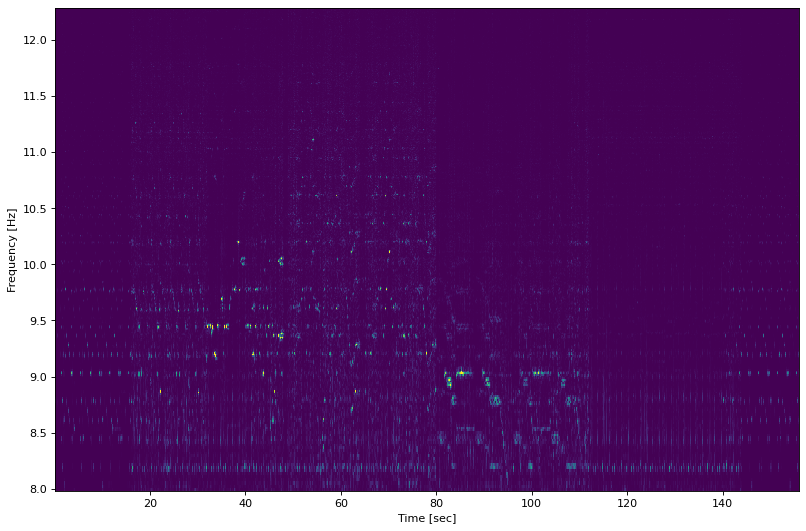

In [12]:
plt.figure(figsize=(12, 8), dpi=80)
freqs = np.where((frequencies >= boundary) & (frequencies <= high_cutoff))[0]
compat_freqs = np.expand_dims(frequencies, 1)
sqrt_spec = np.clip(spectrogram * np.log(compat_freqs), 0.0, 0.15*(spectrogram*np.log(compat_freqs)).max())
plt.pcolormesh(times, np.log2(frequencies[freqs]), sqrt_spec[freqs,:])
# plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Define functions to help calculate led brightnesses

convert frequency value to a cylindrical angle around the tree

In [13]:
a4 = 440.0
def get_angle(freq):
  abs_loc = np.log(freq/a4)/np.log(2)
  angle_loc = (abs_loc % 1) * 2*np.pi
  return angle_loc

use log frequency as hue for the lights

In [14]:
def freq_to_rgb(freq):
  logfreq = np.log2(freq/(low_cutoff + boundary)*0.5) / 5 % 1
  rgb = colorsys.hsv_to_rgb(logfreq,1,1)
  return np.array(rgb)

get all the valid frequencies corresponding to an angle around the tree

In [15]:
def get_freqs(height):
  cap = high_cutoff
  floor = low_cutoff
  oct_loc = height / (2*np.pi)
  f0 = a4 * 2**oct_loc
  octaves = np.array(range(-5,7,1))
  freqs = f0 * 2.0**octaves
  in_bounds = np.logical_and(freqs <= cap, freqs >= floor)
  bounded_freqs = freqs[np.nonzero(in_bounds)]
  return bounded_freqs

simple coordinate transform from carthesian to cylindrical

In [16]:
def to_polar(coords):
  x,y,z = coords
  theta = np.arctan2(y,x)
  return theta, z

get the index on the spectrogram corresponding to a frequency

In [17]:
def freq_to_idx(freq, lower = False):
  if not lower: return np.argmax(freqs > freq) - 1
  else: return np.argmax(low_freqs > freq) - 1

same thing for the time axis for time t (also z coordinate when the spectrogram is rotated and wrapped around the tree, hence the name)

In [18]:
def z_to_idx(z, lower = False):
  if z < 0: return 0
  if not lower: return np.argmax(times > z) - 1
  else: return np.argmax(low_times > z) - 1

transformations that were found to result in prettier light shows and define function to return values from the lower or higher spectrogram

In [19]:
accentuated = spectrogram[freqs,:] * np.log(compat_freqs[freqs])
high_values = np.clip(accentuated / (0.15*accentuated.max()), 0.0, 1.0) * 2.0
low_accentuated = low_spectrogram[low_freqs,:] * np.log(low_compat_freqs[low_freqs])
low_values = low_accentuated / low_accentuated.max()
def get_values(lower):
  return low_values if lower else high_values

brightness at angle theta, height z is the sum of brightnesses at all matching frequencies to the angle at t=z

In [20]:
def get_rgb_brightness(theta, z):
  return np.sum(np.stack([freq_to_rgb(freq) * get_values(freq < boundary)[freq_to_idx(freq, freq < boundary),z_to_idx(z, freq < boundary)] for freq in get_freqs(theta)]),axis=0)

perform coordinate transform first, add slight dependency on the led height to make notes "flow" down

In [21]:
def get_led_brightness(coords, t):
  theta, z = to_polar(coords)
  spec_z = (-0.75 + z) * 0.075 + t
  brightness = get_rgb_brightness(theta, spec_z)
  return brightness

read the led coordinates to memory

In [22]:
led_coords = pd.read_csv('coords.csv', sep=',', names=['x','y','z'], header=None)
led_coords.head()

,x,y,z
0,0.54717,-0.173585,0.698113
1,0.54717,-0.173585,0.698113
2,0.54717,-0.173585,0.698113
3,0.54717,-0.173585,0.698113
4,0.54717,-0.173585,0.698113


In [23]:
coords_arr = led_coords.to_numpy()

calculate brightnesses for all led locations at time t

In [24]:
def get_brightnesses_at_t(coords, t):
  return np.apply_along_axis(lambda x: get_led_brightness(x,t),1,coords)

time a test call

In [25]:
start = time.time()
brightness_cut = get_brightnesses_at_t(coords_arr, 0)
elapsed = time.time() - start
print(elapsed)

0.15772700309753418


define the time vector according to the desired animation fps

In [26]:
update_times = np.arange(0.0,max(times),1 / fps)

list comp ftw (unnecessary to optimize, ~30 min render time isn't that bad)

In [27]:
brightnesses = np.stack([get_brightnesses_at_t(coords_arr, t) for t in update_times])

sanity check, leds should mostly be relatively dim compared to the maximum brightness

In [28]:
print(brightnesses.mean())
print(brightnesses.max())

0.035761671044334455
2.250515576754938


normalization to interval [0,1], clipping values above 0.3 of the maximum to 1 was found to improve the visualization

In [29]:
norm_brightnesses = np.clip(brightnesses / (0.3*brightnesses.max()), 0.0, 1.0)

Check the maximum single frame brightness averaged over leds and colours (should be clearly under 100):

In [30]:
norm_brightnesses.mean(axis=(1,2)).max() * 255

67.78829730067841

Add four flashes with 1 sec intervals to calibrate with music and add FRAME_ID values:

In [31]:
pause = np.zeros((54,1500))
flash = np.ones((6,1500)) * 40
sec = np.concatenate((flash, pause),0)
four_sec = np.concatenate((sec, sec, sec, sec),0)
csv_formatted = np.concatenate((pause, four_sec, np.reshape(norm_brightnesses, (norm_brightnesses.shape[0],) + (-1,)) * 255),0)
csv_formatted = np.concatenate((np.expand_dims(np.arange(len(update_times) + 4*60 + 54),1), csv_formatted),1)

Formatting for the csv file:

In [32]:
rgb_keymap = {0: 'R',
              1: 'G',
              2: 'B'}

In [33]:
cols = ['FRAME_ID',] + [f'{rgb_keymap[n%3]}_{n//3}' for n in range(500*3)]

In [34]:
finished_df = pd.DataFrame(csv_formatted, columns = cols).set_index('FRAME_ID')
finished_df.index = finished_df.index.astype(int)

Check that everything looks correct:

In [35]:
finished_df.tail()

,R_0,G_0,B_0,R_1,G_1,B_1,R_2,G_2,B_2,R_3,G_3,B_3,R_4,G_4,B_4,R_5,G_5,B_5,R_6,G_6,B_6,R_7,G_7,B_7,R_8,G_8,B_8,R_9,G_9,B_9,R_10,G_10,B_10,R_11,G_11,B_11,R_12,G_12,B_12,R_13,...,B_486,R_487,G_487,B_487,R_488,G_488,B_488,R_489,G_489,B_489,R_490,G_490,B_490,R_491,G_491,B_491,R_492,G_492,B_492,R_493,G_493,B_493,R_494,G_494,B_494,R_495,G_495,B_495,R_496,G_496,B_496,R_497,G_497,B_497,R_498,G_498,B_498,R_499,G_499,B_499
FRAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9649,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,0.679899,0.553689,0.487409,...,0.341184,0.631146,0.102553,0.317192,0.060504,0.024953,0.042327,0.470238,0.106884,0.214048,6.836877,2.36899,1.438043,0.756619,0.087813,0.459792,1.562209,0.269505,0.751509,0.811733,0.015469,0.621516,0.586089,0.122426,0.266336,3.172762,0.288149,1.875456,4.729061,1.819837,0.711561,0.363183,0.02641,0.274148,0.360099,0.032385,0.258537,0.360099,0.032385,0.258537
9650,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,0.915366,0.869100,0.849119,...,0.341184,0.631146,0.102553,0.317192,0.051100,0.017235,0.037849,0.475622,0.094578,0.228585,6.836877,2.36899,1.438043,0.756619,0.087813,0.459792,1.562209,0.269505,0.751509,0.811733,0.015469,0.621516,0.586089,0.122426,0.266336,3.172762,0.288149,1.875456,4.729061,1.819837,0.711561,0.363183,0.02641,0.274148,0.360099,0.032385,0.258537,0.360099,0.032385,0.258537
9651,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,0.698974,0.868881,0.945989,...,0.341184,0.631146,0.102553,0.317192,0.051100,0.017235,0.037849,0.475622,0.094578,0.228585,6.836877,2.36899,1.438043,0.756619,0.087813,0.459792,1.562209,0.269505,0.751509,0.811733,0.015469,0.621516,0.586089,0.122426,0.266336,3.172762,0.288149,1.875456,4.729061,1.819837,0.711561,0.363183,0.02641,0.274148,0.360099,0.032385,0.258537,0.360099,0.032385,0.258537
9652,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,0.275298,0.764609,0.946984,...,0.341184,0.631146,0.102553,0.317192,0.051100,0.017235,0.037849,0.475622,0.094578,0.228585,6.836877,2.36899,1.438043,0.756619,0.087813,0.459792,1.562209,0.269505,0.751509,0.811733,0.015469,0.621516,0.586089,0.122426,0.266336,3.172762,0.288149,1.875456,4.729061,1.819837,0.711561,0.363183,0.02641,0.274148,0.360099,0.032385,0.258537,0.360099,0.032385,0.258537
9653,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,0.040133,0.671088,0.878464,...,0.341184,0.631146,0.102553,0.317192,0.051100,0.017235,0.037849,0.475622,0.094578,0.228585,6.836877,2.36899,1.438043,0.756619,0.087813,0.459792,1.562209,0.269505,0.751509,0.811733,0.015469,0.621516,0.586089,0.122426,0.2

Save and download the table:

In [36]:
finished_df.to_csv('megalovania_spectrotree.csv', na_rep='0')

In [37]:
from google.colab import files
files.download('megalovania_spectrotree.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>